In [3]:
import h5py
import numpy as np
import tensorflow as tf
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, fbeta_score
from tensorflow.keras.models import clone_model
import pathlib
from tqdm import tqdm
import sys
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
attack_vector='cache' #network
machine_setting='static_browser_version' # dynamic_browser_version

root_path=f'/content/drive/MyDrive/Colab Notebooks/concept-drift-online'
data_path=f'{root_path}/data/{machine_setting}/{attack_vector}'
model_0_train_path=f'2021_08_27/train.h5'
hdf5_train_path = (pathlib.Path(data_path)/model_0_train_path).as_posix()


In [19]:
os.getcwd()

'/content'

In [20]:
sys.path.append(str(root_path)) # Add the directory to the path
from utils import cnn_lstm,small_cnn_lstm,prepare_hdf5_data,load_hdf5_data,create_subset_encoder,get_data_paths_ordered,predict_on_hdf5

In [21]:

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [22]:
model_path=f'{data_path}/models/cnn_lstm.keras'
le_dir=f'{data_path}/models/label_encoder_100.pkl'
model0 = tf.keras.models.load_model(model_path)
with open(le_dir, 'rb') as f:
    le = pickle.load(f)

In [23]:
ordered_paths=get_data_paths_ordered(data_path)
batch=256
num_of_classes=100

In [ ]:
results={}
for path in tqdm(ordered_paths):
    curr_date_i=path.stem
    test_path_i = (path/'test.h5').as_posix()

    # Load data using load_hdf5_data
    X_test_i, y_test_i = load_hdf5_data(test_path_i,le)

    # Prepare data using prepare_hdf5_data with the loaded data
    test_datasets_i = prepare_hdf5_data(X_test_i, y_test_i, batch_size=batch, sample_validation=-1)['data']
    # Make predictions
    all_predictions = []
    all_true_labels = []
    for features, labels in test_datasets_i:
        batch_predictions = model0.predict_on_batch(features)
        all_predictions.append(batch_predictions)
        all_true_labels.append(labels.numpy()) # Convert label tensor to NumPy array

    pred_i = np.concatenate(all_predictions, axis=0)
    y_testi = np.concatenate(all_true_labels, axis=0)

    acci=(y_testi.argmax(axis=1)==pred_i.argmax(axis=1)).mean()
    results.update({curr_date_i:acci})
    print(f'accuracy: {acci}')

  4%|▍         | 1/26 [00:02<01:10,  2.82s/it]

accuracy: 0.9333333333333333


  8%|▊         | 2/26 [00:03<00:34,  1.44s/it]

accuracy: 0.8404040404040404


 12%|█▏        | 3/26 [00:03<00:22,  1.00it/s]

accuracy: 0.8696969696969697


 15%|█▌        | 4/26 [00:04<00:17,  1.29it/s]

accuracy: 0.7656565656565657


 19%|█▉        | 5/26 [00:04<00:12,  1.64it/s]

accuracy: 0.7363636363636363


 23%|██▎       | 6/26 [00:04<00:10,  1.96it/s]

accuracy: 0.7585858585858586


 27%|██▋       | 7/26 [00:05<00:09,  2.03it/s]

accuracy: 0.7232323232323232


 31%|███       | 8/26 [00:05<00:08,  2.05it/s]

accuracy: 0.7232323232323232


 35%|███▍      | 9/26 [00:06<00:07,  2.13it/s]

accuracy: 0.7080808080808081


 38%|███▊      | 10/26 [00:06<00:07,  2.12it/s]

accuracy: 0.45151515151515154


 42%|████▏     | 11/26 [00:07<00:07,  2.00it/s]

accuracy: 0.6676767676767676


 46%|████▌     | 12/26 [00:07<00:07,  2.00it/s]

accuracy: 0.6404040404040404


 50%|█████     | 13/26 [00:08<00:07,  1.72it/s]

accuracy: 0.693939393939394


 54%|█████▍    | 14/26 [00:08<00:06,  1.80it/s]

accuracy: 0.7252525252525253


 58%|█████▊    | 15/26 [00:09<00:05,  1.87it/s]

accuracy: 0.6787878787878788


 62%|██████▏   | 16/26 [00:10<00:05,  1.74it/s]

accuracy: 0.6393939393939394


 65%|██████▌   | 17/26 [00:10<00:04,  1.81it/s]

accuracy: 0.6434343434343435


 69%|██████▉   | 18/26 [00:11<00:03,  2.02it/s]

accuracy: 0.6242424242424243


 73%|███████▎  | 19/26 [00:11<00:03,  1.89it/s]

accuracy: 0.6757142857142857


 77%|███████▋  | 20/26 [00:11<00:02,  2.14it/s]

accuracy: 0.6444444444444445


 81%|████████  | 21/26 [00:12<00:02,  1.87it/s]

accuracy: 0.6761421319796954


 85%|████████▍ | 22/26 [00:12<00:01,  2.24it/s]

accuracy: 0.6525252525252525


 88%|████████▊ | 23/26 [00:13<00:01,  2.48it/s]

accuracy: 0.6323232323232323


 92%|█████████▏| 24/26 [00:13<00:00,  2.81it/s]

accuracy: 0.5959595959595959


 96%|█████████▌| 25/26 [00:14<00:00,  2.13it/s]

accuracy: 0.14953271028037382


100%|██████████| 26/26 [00:14<00:00,  1.80it/s]

accuracy: 0.6272727272727273


In [24]:
results={}
batch_size=512
n_open_world_labels=30
threshold=0.6

hdf5_train_path = (pathlib.Path(data_path)/'2021_08_27/train.h5').as_posix()

num_of_ow_classes=num_of_classes-n_open_world_labels
X_data, y_data = load_hdf5_data(hdf5_train_path, le, n_samples=-1)
cw_mask=y_data[:,-n_open_world_labels:].any(axis=1)==0
owle=create_subset_encoder(le,num_of_ow_classes)
ow_label=num_of_ow_classes

ow_model_path=f'{data_path}/models/cnn_lstm_ow.keras'
ow_model= tf.keras.models.load_model(ow_model_path)
for path in tqdm(ordered_paths):
    curr_date_i=path.stem
    test_path_i = (path/'test.h5').as_posix()
    X_test_i, y_test_i = load_hdf5_data(test_path_i,le)
    test_datasets_i = prepare_hdf5_data(X_test_i, y_test_i[:,:num_of_ow_classes], batch_size=batch, sample_validation=-1,shuffle=True)['data']
    all_predictions = []
    all_true_labels = []
    for features, labels in test_datasets_i:
        batch_predictions = ow_model.predict_on_batch(features)
        all_predictions.append(batch_predictions)
        all_true_labels.append(labels.numpy())

    pred_i = np.concatenate(all_predictions, axis=0)
    pred_cw_mask_i=pred_i.max(axis=1)>=threshold
    pred_cat_i=pred_i.argmax(axis=1)
    pred_cat_i[~pred_cw_mask_i]=ow_label

    y_test_aligned = np.concatenate(all_true_labels, axis=0)
    y_test_cw_mask=y_test_aligned.any(axis=1)
    y_test_aligned_cat=y_test_aligned.argmax(axis=1)
    y_test_aligned_cat[~y_test_cw_mask]=ow_label

    acci=(pred_cat_i==y_test_aligned_cat).mean()
    y_true_indices = y_test_aligned_cat
    y_pred_indices = pred_cat_i
    precision = precision_score(y_true_indices, y_pred_indices, labels=list(range(num_of_ow_classes)), average='weighted')
    recall = recall_score(y_true_indices, y_pred_indices, labels=list(range(num_of_ow_classes)), average='weighted')
    f2score = fbeta_score(y_true_indices, y_pred_indices, beta=2, labels=list(range(num_of_ow_classes)), average='weighted')
    results.update({curr_date_i: {'accuracy': acci, 'precision': precision, 'recall': recall, 'f2score': f2score}})
    print(f'Date: {curr_date_i}, Accuracy: {acci}, Precision (sensitive): {precision}, Recall (sensitive): {recall}, F2-score (sensitive): {f2score}')


  4%|▍         | 1/26 [00:12<05:09, 12.40s/it]

Date: 2021_08_27, Accuracy: 0.724, Precision (sensitive): 0.8003140067495391, Recall (sensitive): 0.8228571428571428, F2-score (sensitive): 0.8051882175064348


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  8%|▊         | 2/26 [00:15<02:41,  6.71s/it]

Date: 2021_09_05, Accuracy: 0.662, Precision (sensitive): 0.7464114998111007, Recall (sensitive): 0.7885714285714286, F2-score (sensitive): 0.7611813527112534


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 12%|█▏        | 3/26 [00:18<02:00,  5.26s/it]

Date: 2021_09_12, Accuracy: 0.729, Precision (sensitive): 0.7732208038849994, Recall (sensitive): 0.8471428571428572, F2-score (sensitive): 0.8157894984147503


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 15%|█▌        | 4/26 [00:21<01:35,  4.32s/it]

Date: 2021_09_24, Accuracy: 0.673, Precision (sensitive): 0.7477870839385617, Recall (sensitive): 0.8214285714285714, F2-score (sensitive): 0.7886113902062587


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 19%|█▉        | 5/26 [00:23<01:16,  3.64s/it]

Date: 2021_09_28, Accuracy: 0.698, Precision (sensitive): 0.7464671902171902, Recall (sensitive): 0.8228571428571428, F2-score (sensitive): 0.7887434449471531


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 23%|██▎       | 6/26 [00:26<01:07,  3.39s/it]

Date: 2021_10_03, Accuracy: 0.666, Precision (sensitive): 0.6992681276534659, Recall (sensitive): 0.78, F2-score (sensitive): 0.7454462771117096


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 27%|██▋       | 7/26 [00:29<00:58,  3.10s/it]

Date: 2021_10_10, Accuracy: 0.691, Precision (sensitive): 0.7505290122800498, Recall (sensitive): 0.7988587731811697, F2-score (sensitive): 0.7684755283946352


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 31%|███       | 8/26 [00:34<01:04,  3.60s/it]

Date: 2021_10_17, Accuracy: 0.6402805611222445, Precision (sensitive): 0.7068761101154635, Recall (sensitive): 0.748211731044349, F2-score (sensitive): 0.7165818408450586


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 35%|███▍      | 9/26 [00:37<01:00,  3.56s/it]

Date: 2021_10_24, Accuracy: 0.6768642447418738, Precision (sensitive): 0.7273846146687412, Recall (sensitive): 0.7741496598639456, F2-score (sensitive): 0.7444435171116369


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 38%|███▊      | 10/26 [00:40<00:53,  3.34s/it]

Date: 2021_10_31, Accuracy: 0.575, Precision (sensitive): 0.6699790549038466, Recall (sensitive): 0.6714285714285714, F2-score (sensitive): 0.6415420605792713


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 42%|████▏     | 11/26 [00:43<00:47,  3.16s/it]

Date: 2021_11_07, Accuracy: 0.605, Precision (sensitive): 0.6905718612052094, Recall (sensitive): 0.7171428571428572, F2-score (sensitive): 0.6836331681969264


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 46%|████▌     | 12/26 [00:45<00:41,  2.98s/it]

Date: 2021_11_14, Accuracy: 0.562, Precision (sensitive): 0.6490033255625145, Recall (sensitive): 0.6528571428571428, F2-score (sensitive): 0.6245984968595135


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 50%|█████     | 13/26 [00:48<00:37,  2.89s/it]

Date: 2021_11_21, Accuracy: 0.606, Precision (sensitive): 0.6651997496869908, Recall (sensitive): 0.7085714285714285, F2-score (sensitive): 0.6727278783648095


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 54%|█████▍    | 14/26 [00:51<00:35,  2.99s/it]

Date: 2021_11_28, Accuracy: 0.625, Precision (sensitive): 0.6608445104957938, Recall (sensitive): 0.6957142857142857, F2-score (sensitive): 0.6717049538604601


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 58%|█████▊    | 15/26 [00:54<00:31,  2.86s/it]

Date: 2021_12_05, Accuracy: 0.623, Precision (sensitive): 0.6818118771861584, Recall (sensitive): 0.6971428571428572, F2-score (sensitive): 0.6687039497563708


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 62%|██████▏   | 16/26 [00:57<00:30,  3.08s/it]

Date: 2021_12_12, Accuracy: 0.602, Precision (sensitive): 0.6582568734091937, Recall (sensitive): 0.6871428571428572, F2-score (sensitive): 0.6619344414603978


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 65%|██████▌   | 17/26 [01:00<00:26,  2.93s/it]

Date: 2021_12_19, Accuracy: 0.601, Precision (sensitive): 0.615053474401661, Recall (sensitive): 0.6614285714285715, F2-score (sensitive): 0.6380092505863337


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 69%|██████▉   | 18/26 [01:05<00:28,  3.60s/it]

Date: 2021_12_26, Accuracy: 0.573134328358209, Precision (sensitive): 0.6390292746889965, Recall (sensitive): 0.6278409090909091, F2-score (sensitive): 0.6110309832003938


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 73%|███████▎  | 19/26 [01:10<00:27,  3.91s/it]

Date: 2022_01_02, Accuracy: 0.6186274509803922, Precision (sensitive): 0.6499699953845909, Recall (sensitive): 0.6759776536312849, F2-score (sensitive): 0.6487346436542856


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 77%|███████▋  | 20/26 [01:15<00:25,  4.25s/it]

Date: 2022_01_09, Accuracy: 0.597029702970297, Precision (sensitive): 0.6357822431026683, Recall (sensitive): 0.6680790960451978, F2-score (sensitive): 0.6408523418365702


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 81%|████████  | 21/26 [01:17<00:18,  3.79s/it]

Date: 2022_01_16, Accuracy: 0.5791044776119403, Precision (sensitive): 0.6016589251418296, Recall (sensitive): 0.640625, F2-score (sensitive): 0.6119209874866217


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 85%|████████▍ | 22/26 [01:20<00:14,  3.51s/it]

Date: 2022_01_23, Accuracy: 0.59, Precision (sensitive): 0.5978235683550809, Recall (sensitive): 0.66, F2-score (sensitive): 0.6243820962376068


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 88%|████████▊ | 23/26 [01:23<00:09,  3.21s/it]

Date: 2022_01_30, Accuracy: 0.575, Precision (sensitive): 0.5947905857067481, Recall (sensitive): 0.6628571428571428, F2-score (sensitive): 0.6261345229741108


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 92%|█████████▏| 24/26 [01:25<00:06,  3.06s/it]

Date: 2022_02_06, Accuracy: 0.563, Precision (sensitive): 0.5684574189460926, Recall (sensitive): 0.6285714285714286, F2-score (sensitive): 0.595727185426188


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 96%|█████████▌| 25/26 [01:31<00:03,  3.88s/it]

Date: 2022_02_16, Accuracy: 0.20353982300884957, Precision (sensitive): 0.11415888731396316, Recall (sensitive): 0.1432192648922687, F2-score (sensitive): 0.12128110941667633


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 26/26 [01:34<00:00,  3.63s/it]

Date: 2022_02_21, Accuracy: 0.503, Precision (sensitive): 0.565786263223238, Recall (sensitive): 0.5614285714285714, F2-score (sensitive): 0.5330602171554836


<Axes: >

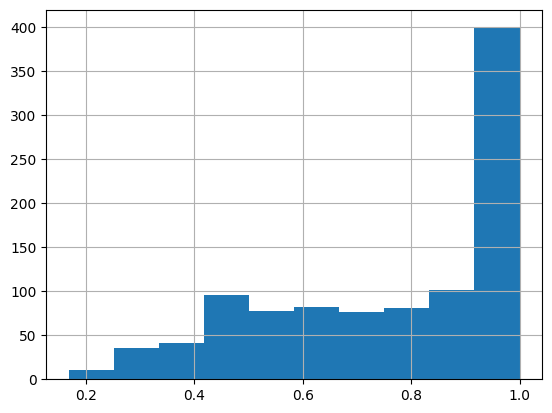

In [25]:
import pandas as pd

pd.Series(pred_i.max(axis=1)).hist()

In [26]:
import json
import pandas as pd
with open(data_path+'/baseline-ow.json','w') as f:
   json.dump(pd.DataFrame(results).to_json(), f)

In [27]:
data_path+'/baseline-ow.json'

'/content/drive/MyDrive/Colab Notebooks/concept-drift-online/data/static_browser_version/cache/baseline-ow.json'